## Generation

In [69]:
# Critic Chain: Takes a hypothesis and provides a critique.
critic_template = """
Given the following hypothesis:
{hypothesis}

Analyze each part of the hypothesis:
1. Clarity: Are the statements clear and easy to understand?
2. Coherence: Do the different parts of the hypothesis logically flow together? Does it seem like the proposed solution would work?
3. Scientific Validity: Are there any scientific inaccuracies or assumptions that seem unfounded?

After your analysis, provide specific feedback on how each field (Problem, Solution, Methodology, Evaluation, Results) can be improved.
"""
critic_prompt = PromptTemplate(input_variables=["hypothesis"], template=critic_template)
critic_chain = LLMChain(llm=llm, prompt=critic_prompt, output_key="critique")

# Reviser Chain: Takes original hypothesis and critique, then provides a revised hypothesis.
reviser_template = """
Given the original hypothesis:
{hypothesis}

And based on the critique provided:
{critique}

Revise the hypothesis by addressing each point of the critique. Ensure the new version is clearer, more coherent, and scientifically valid.
"""
reviser_prompt = PromptTemplate(input_variables=["hypothesis", "critique"], template=reviser_template)
reviser_chain = LLMChain(llm=llm, prompt=reviser_prompt, output_key="revised_hypothesis")

# Overall Sequential Chain: Critiques the hypothesis and then revises it.
overall_chain = SequentialChain(
    chains=[critic_chain, reviser_chain],
    input_variables=["hypothesis"],
    output_variables=["critique", "revised_hypothesis"],
    verbose=True)

# Test the chain with a provided hypothesis
hypothesis = {
    "Problem": "Issues in determining basic characteristics of black holes and their surrounding disks in X-ray binary, using models of the source's disk X-ray continuum. A key issue is the determination of the \"color correction factor\".",
    "Solution": "Using observational data to estimate the color correction factor by modeling the disk spectrum with saturated Compton scattering.",
    "Methodology": "The work is based on two observations made by XMM-Newton on GX 339-4. These observations offer high-quality data at low energies. The spectra were then fitted to these models.",
    "Evaluation": "The quality of fit of the spectra to the models was examined. Other models were also tested for fit.",
    "Results": "The spectra fits well with the model and provides reasonable values for the color correction factor. However, the high-soft-state continuum cannot be adequately fitted by the latest disk models."
}
result = overall_chain({"hypothesis": str(hypothesis)})




> Entering new SequentialChain chain...

> Finished chain.


In [70]:
print(result['critique'])

Analysis:

1. Clarity: The hypothesis is relatively clear but contains technical terms that may be difficult for non-experts to understand. For example, terms like "X-ray binary", "color correction factor", "saturated Compton scattering", and "high-soft-state continuum" may require more explanation or context.
   
2. Coherence: The different parts of the hypothesis logically flow together. The problem is clearly stated, a solution is proposed, the methodology is explained, an evaluation process is detailed, and results are provided. 

3. Scientific Validity: The hypothesis appears to be scientifically valid. It uses real-world observational data and incorporates established scientific models. However, the validity of the results would depend on the accuracy and reliability of the data and models used.

Feedback:

Problem: The problem statement could be improved by providing more background information to help non-experts understand the issue. For example, briefly explaining what a blac

In [71]:
print(result['revised_hypothesis'])

{'Problem': 'The study aims to determine basic attributes of black holes and their surrounding disks, specifically in X-ray binary systems. In simple terms, X-ray binaries are systems where a black hole and a star are in close proximity, and the intense gravitational pull of the black hole causes matter from the star to form a disk around the black hole. The main challenge is the determination of the "color correction factor", a numerical factor that helps us to understand the temperature and energy of the emitting source.', 

'Solution': 'The proposed solution is to estimate the color correction factor using observational data. This is achieved by modeling the spectrum of the disk around the black hole with a phenomenon known as saturated Compton scattering, where photons gain energy by interacting with high-energy particles.', 

'Methodology': 'The research utilized two observational datasets provided by the XMM-Newton space telescope on the X-ray binary system GX 339-4. The high-qua

In [72]:
import ast

hypothesis_dict = ast.literal_eval(result['revised_hypothesis'])

In [1]:
import ast
import yaml
from langchain.chains import SequentialChain
from langchain.memory import SimpleMemory
from langchain.chat_models import AzureChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# This is an LLMChain to write a synopsis given a title of a play.
config = yaml.safe_load(open("../config.yml"))
API_KEY = config['api_key']
DEPLOYMENT_NAME = config['deployment_name']
BASE_URL = config['base_url']
API_VERSION = config['api_version']

llm = AzureChatOpenAI(
    openai_api_base=BASE_URL,
    openai_api_version=API_VERSION,
    deployment_name=DEPLOYMENT_NAME,
    openai_api_key=API_KEY,
    openai_api_type="azure",
)

# Critic Chain: Takes a hypothesis and provides a critique.
critic_template = """
Given the following hypothesis:
{hypothesis}

Analyze each part of the hypothesis:
1. Clarity: Are the statements clear and easy to understand?
2. Coherence: Do the different parts of the hypothesis logically flow together? Does it seem like the proposed solution would work?
3. Scientific Validity: Are there any scientific inaccuracies or assumptions that seem unfounded?

After your analysis, provide specific feedback on how each field (Problem, Solution, Methodology, Evaluation, Results) can be improved.
Specifically, give feedback on the frailties of the idea as a whole, and suggest potential enhancements.
"""

# Reviser Chain: Takes original hypothesis and critique, then provides a revised hypothesis.
reviser_template = """
Given the original hypothesis:
{hypothesis}

And based on the critique provided:
{critique}

Revise the hypothesis by addressing each point of the critique. Ensure the new version is clearer, more coherent, and scientifically valid.
"""

def adversarial_update_hypothesis(hypothesis):
    critic_prompt = PromptTemplate(input_variables=["hypothesis"], template=critic_template)
    critic_chain = LLMChain(llm=llm, prompt=critic_prompt, output_key="critique")
    reviser_prompt = PromptTemplate(input_variables=["hypothesis", "critique"], template=reviser_template)
    reviser_chain = LLMChain(llm=llm, prompt=reviser_prompt, output_key="revised_hypothesis")
    overall_chain = SequentialChain(
        chains=[critic_chain, reviser_chain],
        input_variables=["hypothesis"],
        output_variables=["critique", "revised_hypothesis"],
        verbose=False)
    result = overall_chain({"hypothesis": str(hypothesis)})
    return result

In [2]:
import re
from preprocessing import Hypothesis
from tqdm.notebook import tqdm

def improve_hypothesis(hypothesis: str, n_iters: int = 3) -> str:
    for i in tqdm(range(n_iters)):
        revised_hypothesis = adversarial_update_hypothesis(hypothesis)
        hyp_str = revised_hypothesis['revised_hypothesis']
        hyp_str = hyp_str.replace('\n', ' ')
        # Remove everything before the first { and after the last }
        hyp_str = re.sub(r'^.*?\{', '{', hyp_str)
        hypothesis = hyp_str
    return hypothesis

hypothesis_to_improve = {
    "Problem": "Issues in determining basic characteristics of black holes and their surrounding disks in X-ray binary, using models of the source's disk X-ray continuum. A key issue is the determination of the \"color correction factor\".",
    "Solution": "Using observational data to estimate the color correction factor by modeling the disk spectrum with saturated Compton scattering.",
    "Methodology": "The work is based on two observations made by XMM-Newton on GX 339-4. These observations offer high-quality data at low energies. The spectra were then fitted to these models.",
    "Evaluation": "The quality of fit of the spectra to the models was examined. Other models were also tested for fit.",
    "Results": "The spectra fits well with the model and provides reasonable values for the color correction factor. However, the high-soft-state continuum cannot be adequately fitted by the latest disk models."
}

improve_hypothesis(hypothesis=hypothesis_to_improve, n_iters=3)

  0%|          | 0/3 [00:00<?, ?it/s]

'{\'Problem\': \'We are tasked with the challenge of accurately determining the fundamental features of black holes and the disks that surround them in X-ray binary, a type of binary star system that emits X-rays. This process is pivotal to enhancing our understanding of how matter behaves in extreme gravitational fields and the nature of black holes. The importance of achieving this lies in its potential to contribute significantly to the broader field of astrophysics, enabling us to understand the universe better. The critical part of this process is the determination of the "color correction factor", a measure of how the color of an object appears to change due to relativistic effects when it is moving at speeds close to the speed of light.\',   \'Solution\': \'We propose a solution that utilizes observational data to derive estimates for the color correction factor. This involves modeling the disk spectrum through the innovative concept of "saturated Compton scattering". In this pr

In [18]:
import pandas as pd

df = pd.read_csv("../data/tuning/cs.LG.csv")
print(f"There are {len(df)} hypotheses in the dataset.")
abstracts = pd.read_csv("../data/processed/arxiv-cs.LG.csv", low_memory=False)
print(f"There are {len(abstracts)} abstracts in the dataset.")

There are 83923 hypotheses in the dataset.
There are 147502 abstracts in the dataset.


In [23]:
# Randomly sample a row from the dataframe
# Generate random number in (0, len(df))
import random

random_idx = random.randint(0, len(df)-1)
print('-'*75)
print(df.iloc[random_idx]['title'])
print('-'*75)
print("Bit: "+df.iloc[random_idx]['bit']+"\n")
print("Flip: "+df.iloc[random_idx]['flip'])

---------------------------------------------------------------------------
Faithful Inversion of Generative Models for Effective Amortized
  Inference
---------------------------------------------------------------------------
Bit: Inference amortization methods are traditionally used to share information across multiple posterior-inference problems, enhancing their efficiency. However, these methods typically require the inversion of the dependency structure in the generative model, which involves learning a mapping from observations to distributions approximating the posterior. Previous approaches have attempted to invert the dependency structure in a heuristic way, but these methods often fail to capture these dependencies correctly, limiting the accuracy of the resulting approximations.

Flip: The research introduces an algorithm that minimally and faithfully inverts the graphical model structure of any generative model. This new approach ensures that the inverses do not encode an

In [60]:
# Get the original abstract using the index
title = df.iloc[random_idx]['title']
corresponding_idx = int(abstracts[abstracts.title == title].index[0])
print('-'*75)
print(abstracts.iloc[corresponding_idx]['title'])
print()
print(abstracts.iloc[corresponding_idx]['abstract'])

---------------------------------------------------------------------------
An Atomistic Machine Learning Package for Surface Science and Catalysis

  We present work flows and a software module for machine learning model
building in surface science and heterogeneous catalysis. This includes
fingerprinting atomic structures from 3D structure and/or connectivity
information, it includes descriptor selection methods and benchmarks, and it
includes active learning frameworks for atomic structure optimization,
acceleration of screening studies and for exploration of the structure space of
nano particles, which are all atomic structure problems relevant for surface
science and heterogeneous catalysis. Our overall goal is to provide a
repository to ease machine learning model building for catalysis, to advance
the models beyond the chemical intuition of the user and to increase autonomy
for exploration of chemical space.



In [68]:
# Find all the rows which have the word 'transformer' in the abstract column
transformer_rows = abstracts[abstracts['abstract'].str.contains("attention")]
print(transformer_rows.iloc[1]['abstract'])

  Statistically resolving the underlying haplotype pair for a genotype
measurement is an important intermediate step in gene mapping studies, and has
received much attention recently. Consequently, a variety of methods for this
problem have been developed. Different methods employ different statistical
models, and thus implicitly encode different assumptions about the nature of
the underlying haplotype structure. Depending on the population sample in
question, their relative performance can vary greatly, and it is unclear which
method to choose for a particular sample. Instead of choosing a single method,
we explore combining predictions returned by different methods in a principled
way, and thereby circumvent the problem of method selection.
  We propose several techniques for combining haplotype reconstructions and
analyze their computational properties. In an experimental study on real-world
haplotype data we show that such techniques can provide more accurate and
robust reconstruct

## Pushing dataset to HuggingFace

In [49]:
import pandas as pd

category = 'cs.LG'
df = pd.read_csv(f"../data/tuning/{category}.csv")
print(f"There are {len(df)} hypotheses in the dataset.")
abstracts = pd.read_csv(f"../data/processed/arxiv-{category}.csv", low_memory=False)
print(f"There are {len(abstracts)} abstracts in the dataset.")

There are 22982 hypotheses in the dataset.
There are 147502 abstracts in the dataset.


In [50]:
# Merge the df and abstracts dataframes on title
merged_df = pd.merge(df, abstracts, on='title')
merged_df.drop(columns=['index'], inplace=True)
print(f"There are {len(merged_df)} hypotheses in the merged dataset.")
merged_df.to_csv(f"../data/processed/hf-{category}.csv", index=False)


There are 23076 hypotheses in the merged dataset.


In [51]:
merged_df.head()

,bit,flip,title,categories,abstract,authors,doi,id
0,Traditional statistical learning constructs a ...,The research proposes a setting where the enco...,Learning from compressed observations,cs.IT cs.LG math.IT,The problem of statistical learning is to co...,Maxim Raginsky,10.1109/ITW.2007.4313111,0704.0671
1,"In sensor networks, the communication among se...",This research proposes a new approach to desig...,Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,"In a sensor network, in practice, the commun...",Soummya Kar and Jose M. F. Moura,10.1109/TSP.2008.920143,0704.0954
2,Traditional algorithms for the online shortest...,An innovative approach is to develop an algori...,The on-line shortest path problem under partia...,cs.LG cs.SC,The on-line shortest path problem is conside...,"Andras Gyorgy, Tamas Linder, Gabor Lugosi, Gyo...",NaN,0704.1020
3,"Ordinal regression, a type of learning that co...",A traditional neural network can be adapted to...,A neural network approach to ordinal regression,cs.LG cs.AI cs.NE,Ordinal regression is an important type of l...,Jianlin Cheng,NaN,0704.1028
4,Traditional Monte Carlo Optimization (MCO) and...,This research establishes a mathematical ident...,Parametric Learning and Monte Carlo Optimization,cs.LG,This paper uncovers and explores the close r...,David H. Wolpert and Dev G. Rajnarayan,NaN,0704.1274


In [57]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files=f"../data/processed/hf-{category}.csv", split='train')
dataset.push_to_hub(f"universeTBD/arxiv-bit-flip-{category}")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

In [56]:
dataset[0]

{'bit': 'Traditional statistical learning constructs a predictor of a random variable Y as a function of a related random variable X, based on a training sample from their joint distribution. The goal is to approach the performance of the best predictor in the specified class. This approach assumes perfect observation of the X-part of the sample, while the Y-part is communicated at some finite bit rate.',
 'flip': 'The research proposes a setting where the encoding of the Y-values is allowed to depend on the X-values. Under certain conditions on the admissible predictors, the underlying family of probability distributions, and the loss function, an information-theoretic characterization of achievable predictor performance is given. This is based on conditional distortion-rate functions, illustrating a new approach to nonparametric regression in Gaussian noise.',
 'title': 'Learning from compressed observations',
 'categories': 'cs.IT cs.LG math.IT',
 'abstract': '  The problem of stati

In [111]:
path = '../data/generated/gpt_4_zero_shot.csv'
df = pd.read_csv(path)

# # iterate over rows
# for index, row in df.iterrows():
#     print(f'Bit: {row["Bit"]}')
#     result = row["Flip"]
#     if result.startswith("Flip: "):
#         result = result[len("Flip: "):]
#     print(f'Flip: {result}')
#     print()
df.shape

(1005, 3)

In [89]:
path = '../data/tuning/cs.LG_test.csv'
test = pd.read_csv(path)

# iterate over rows
i = 0
for index, row in test.iterrows():
    print(f'Bit: {row["bit"]}')
    result = row["flip"]
    if result.startswith("flip: "):
        result = result[len("flip: "):]
    print(f'Flip: {result}')
    print()
    i += 1
    if i == 5: break

Bit: Graph anomaly detection (GAD) has been successful in various fields, including fraud detection, cybersecurity, and finance security. The conventional approach focuses on identifying anomalies at the level of individual entities, such as nodes or graphs. This approach, however, overlooks the potential existence of anomalous groups within the graph.
Flip: A new approach is proposed that focuses on Group-level Graph Anomaly Detection (Gr-GAD), challenging the traditional focus on individual entities. This method uses a variant of Graph AutoEncoder (GAE) to identify potential anomaly groups, and then applies a Topology Pattern-based Graph Contrastive Learning (TPGCL) method to generate embeddings for each candidate group. This innovative approach allows for the identification and localization of anomaly groups, providing a more comprehensive understanding of graph anomalies.

Bit: The conventional belief in supervised learning is that boosting involves combining multiple weak classifi

## Plots

### Perplexity plot

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import wandb

# Initialise the API
api = wandb.Api()

run_path = "charlieoneill/huggingface/n6d3utay"

# Get the run object
run = api.run(run_path)

# Retrieve the training loss from the run's history
history = run.history(samples=2500)
history.rename(columns={'train/loss': 'cross_entropy_loss'}, inplace=True)
history['perplexity'] = history['cross_entropy_loss'].apply(lambda x: 2**x)

# Do the same for new run path
run_path = "charlieoneill/huggingface/g4yzci4n"
run = api.run(run_path)
new_history = run.history(samples=2500)
new_history.rename(columns={'train/loss': 'cross_entropy_loss'}, inplace=True)
new_history['perplexity'] = new_history['cross_entropy_loss'].apply(lambda x: 2**x)

# Concatenate the two histories
history = pd.concat([history, new_history])
history.reset_index(inplace=True, drop=True)

# Fill nans in perplexity column
history['perplexity'].fillna(method='ffill', inplace=True)

# Print number of steps
print(f"There are {len(history)} steps in the training history.")

There are 4751 steps in the training history.


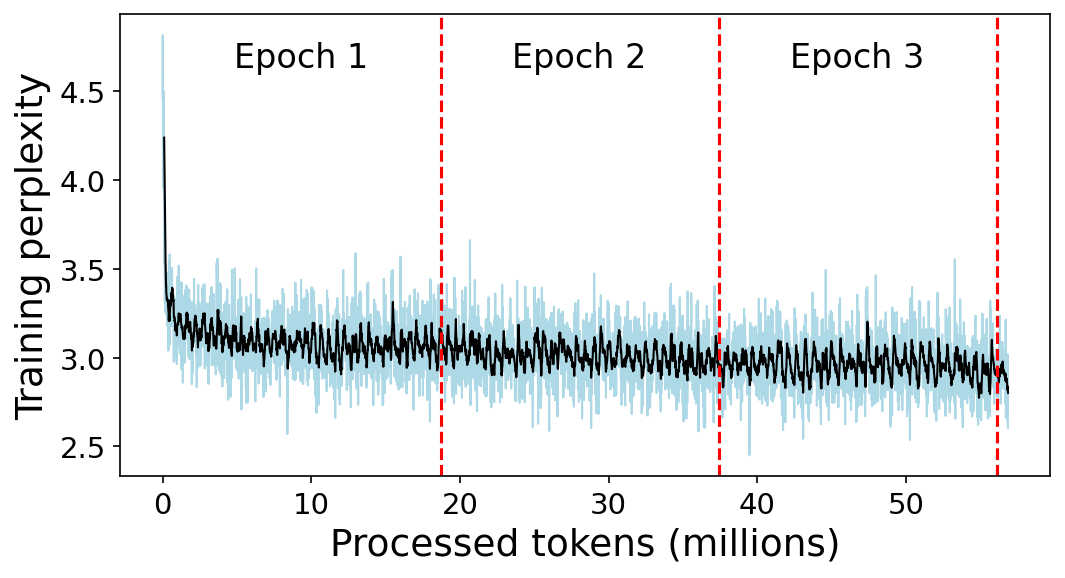

In [202]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math

# Set up the figure with specified dpi
plt.figure(figsize=(8, 4), dpi=150)

data = history.copy()

# Define the moving_average function
def moving_average(data, window_size):
    return [sum(data[i:i + window_size]) / window_size for i in range(len(data) - window_size + 1)]

# Define step
step = [i for i in range(len(data))]

# Define variables
number_of_gpus = 4
number_of_samples = 100000
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
mean_tokens_per_sample = 187

# Calculate Effective Batch Size and Tokens per Step
effective_batch_size = per_device_train_batch_size * gradient_accumulation_steps * number_of_gpus
tokens_per_step = effective_batch_size * mean_tokens_per_sample

# Convert step to Processed Tokens (millions)
processed_tokens_millions = [s * tokens_per_step / 1e6 for s in step]

# Plot Actual Perplexity with new x-axis
plt.plot(processed_tokens_millions, data.perplexity, color='lightblue', label='Actual Perplexity', lw=1.0)

# Calculate and plot Smoothed Perplexity with new x-axis
window_size = 10
smoothed_perplexity = moving_average(data.perplexity, window_size)
smoothed_steps = step[window_size - 1:]
smoothed_processed_tokens_millions = [s * tokens_per_step / 1e6 for s in smoothed_steps]
plt.plot(smoothed_processed_tokens_millions, smoothed_perplexity, color='black', label='Smoothed Perplexity', lw=1.0)

# Calculate the step at which each epoch ends and draw vertical dashed lines with new x-axis
epoch_end_step = number_of_samples // effective_batch_size
number_of_steps = len(step)
number_of_epochs_with_gpus = math.ceil(number_of_steps * effective_batch_size / number_of_samples)

for epoch in range(1, number_of_epochs_with_gpus):
    x_coordinate_tokens = epoch * epoch_end_step * tokens_per_step / 1e6
    plt.axvline(x=x_coordinate_tokens, color='red', linestyle='dashed', lw=1.5)
    
    middle_x_coordinate_tokens = x_coordinate_tokens - (epoch_end_step * tokens_per_step / 1e6) / 2
    plt.text(middle_x_coordinate_tokens, plt.ylim()[1] * 0.95, f'Epoch {epoch}', ha='center', va='center', color='black', fontsize=16)

# Set title, labels, legend and save the figure
plt.xlabel('Processed tokens (millions)', fontsize=18)
plt.ylabel('Training perplexity', fontsize=18)
# Set y-axis ticks to be integers
#plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("../paper/figures/perplexity.pdf", dpi=300, bbox_inches="tight")
plt.show()

### Median example length in tokens

In [167]:
import pandas as pd
from transformers import LlamaForCausalLM, LlamaTokenizer
import torch

df = pd.read_csv("../data/tuning/cs.LG.csv", low_memory=False)
print(f"There are {len(df)} hypotheses in the dataset.")

tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-70b-hf")

There are 99874 hypotheses in the dataset.


In [169]:
from tqdm import tqdm

tqdm.pandas()

def preprocess_data(example):
    example['text'] = 'Bit: ' + example['bit'] + ' Flip: ' + example['flip']
    return example

# Map the preprocessing function to the dataset
hypotheses = df.progress_apply(preprocess_data, axis=1)
hypotheses

100%|██████████| 99874/99874 [00:13<00:00, 7409.78it/s] 


,index,bit,flip,title,text
0,0,Traditional statistical learning constructs a ...,The research proposes a setting where the enco...,Learning from compressed observations,Bit: Traditional statistical learning construc...
1,1,"In sensor networks, the communication among se...",This research proposes a new approach to desig...,Sensor Networks with Random Links: Topology De...,"Bit: In sensor networks, the communication amo..."
2,2,Traditional algorithms for the online shortest...,An innovative approach is to develop an algori...,The on-line shortest path problem under partia...,Bit: Traditional algorithms for the online sho...
3,3,"Ordinal regression, a type of learning that co...",A traditional neural network can be adapted to...,A neural network approach to ordinal regression,"Bit: Ordinal regression, a type of learning th..."
4,4,Traditional Monte Carlo Optimization (MCO) and...,This research establishes a mathematical ident...,Parametric Learning and Monte Carlo Optimization,Bit: Traditional Monte Carlo Optimization (MCO...
...,...,...,...,...,...
99869,100035,Graph neural networks (GNNs) are widely used i...,"However, this research presents a counterexamp...",Incompleteness of graph neural networks for po...,Bit: Graph neural networks (GNNs) are widely u...
99870,100036,"In online advertising, the conventional approa...",This research proposes the use of combinatoria...,Safe Online Bid Optimization with Return-On-In...,"Bit: In online advertising, the conventional a..."
99871,100037,"Traditional global optimization algorithms, su...",The proposed algorithm flips the focus from si...,Low Regret Binary Sampling Method for Efficien...,Bit: Traditional global optimization algorithm...
99872,100038,Traditional methods in jet physics rely on spe...,A new approach leverages representation learni...,Invariant Representation Driven Neural Classif...,Bit: Traditional methods in jet physics rely o...


In [170]:
def count_tokens(example):
    return len(tokenizer(example['text'])['input_ids'])

# Map the count_tokens function to the dataset
hypotheses['num_tokens'] = hypotheses.progress_apply(count_tokens, axis=1)

100%|██████████| 99874/99874 [01:15<00:00, 1315.45it/s]


In [14]:
# Print out the statistics of the number of tokens
print(hypotheses['num_tokens'].describe())
# Print median number of tokens
print(f"Median number of tokens: {hypotheses['num_tokens'].median()}")
# Print total number of tokens in millions
print(f"Total number of tokens: {hypotheses['num_tokens'].sum()/1000000}M")

count    79829.000000
mean       187.391737
std         24.496813
min         46.000000
25%        171.000000
50%        186.000000
75%        203.000000
max        335.000000
Name: num_tokens, dtype: float64
Median number of tokens: 186.0
Total number of tokens: 14.959295M


# Look at results

In [209]:
import random

path = "../data/generated"
method = "gpt_4_zero_shot"

# Load the results
gpt_4_zero_shot = pd.read_csv(f"{path}/gpt_4_zero_shot.csv")
gpt_4_three_shot = pd.read_csv(f"{path}/gpt_4_three_shot.csv")
llama_three_shot = pd.read_csv(f"{path}/llama_three_shot.csv")
llama_finetuned_three_shot = pd.read_csv(f"{path}/llama_finetuned_three_shot.csv")

# Shuffle the df
df = df.sample(frac=1)
real = pd.read_csv(f"{path}/real.csv")

# Print some bit flip examples, along with the corresponding real hypothesis
# Random idx
i = random.randint(0, len(df)-1)
print('-'*50)
print(f'Bit: {real.iloc[i]["bit"]}')
print('-'*50)
print(f'GPT-4 (zero shot): {gpt_4_zero_shot.iloc[i]["flip"]}')
print('-'*50)
print(f'GPT-4 (three shot): {gpt_4_three_shot.iloc[i]["flip"]}')
print('-'*50)
print(f'LLAMA (three shot): {llama_three_shot.iloc[i]["flip"]}')
print('-'*50)
print(f'LLAMA (finetuned three shot): {llama_finetuned_three_shot.iloc[i]["flip"]}')
print('-'*50)
print(f'Real: {real.iloc[i]["flip"]}')
print('-'*50)
print()

--------------------------------------------------
Bit: The conventional belief in online decision strategies, such as "Follow the Perturbed Leader" (FPL), is that regret bounds are typically proven against an oblivious adversary. In cases of partial observation, it has been unclear how to obtain performance guarantees against an adaptive adversary without worsening the bounds. This limitation has been a significant challenge in the field, restricting the effectiveness of FPL strategies in adversarial multi-armed bandit problems.
--------------------------------------------------
GPT-4 (zero shot): Instead of focusing on regret bounds against an oblivious adversary, we can shift our focus to learning and adapting to the adversary's strategy in real-time. This approach would involve developing a model that can predict the adversary's actions based on past behavior and adjust its strategy accordingly. By doing so, we can potentially achieve better performance against an adaptive adversar